In [ ]:
import os, sys
import yaml
import torch
import anndata
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from anndata.experimental.pytorch import AnnLoader
from tqdm import tqdm

%matplotlib inline

In [5]:
sys.path.append('..')

from src.costs import quadratic_cost, l2_squared_cost
from src.plotters import plot_results
from src.regularizers import entropic_regularizer, conservativity_regularizer
from src.mlp import MLPQuadratic
from src.metrics import sinkhorn_distance

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0x000000); np.random.seed(0x000000)

# Dataset setup

In [7]:
def make_infinite_loader(loader):
    while True:
        for batch in loader:
            yield batch


class CellSampler:
    def __init__(self, ann_data, **loader_kwargs):
        loader = AnnLoader(ann_data, **loader_kwargs)
        self.loader = make_infinite_loader(loader)

    def sample(self):
        return next(self.loader).X.float()

In [8]:
def get_train_test_datasests(dataset, drug, test_size, random_state=0):
    control_dataset = dataset[dataset.obs.drug == 'control']
    treated_dataset = dataset[dataset.obs.drug == drug]
    control_split = train_test_split(control_dataset, test_size=test_size, random_state=random_state)
    treated_split = train_test_split(treated_dataset, test_size=test_size, random_state=random_state)

    return *control_split, *treated_split

In [9]:
base_path = os.path.join('../', 'experiments_data', '4i')

with open(os.path.join(base_path, 'features.txt')) as features_file:
    features = [line.strip() for line in features_file.readlines()]

dataset = anndata.read_h5ad(os.path.join(base_path, '8h.h5ad'))[:, features]

In [15]:
drugs = [
    'cisplatin',
    'dabrafenib',
    'erlotinib',
    'ixazomib',
    'lenalidomide',
    'mln2480',
    'paclitaxel',
    'sorafenib',
    'staurosporine',
    'trametinib_dabrafenib'
]

with open(os.path.join(base_path, 'params.yaml')) as params_file:
    experiment_params = yaml.safe_load(params_file)

# Evaluate metrics

In [16]:
def load_models(drug):
    base_path = os.path.join('../', 'checkpoints', '4i')

    model_mlp = MLPQuadratic(len(features), experiment_params['hidden_sizes']).to(device)
    model_mlp.load_state_dict(torch.load(os.path.join(base_path, f'{drug}_mlp.pt')))
    model_mlp.eval()

    model_reg = MLPQuadratic(len(features), experiment_params['hidden_sizes']).to(device)
    model_reg.load_state_dict(torch.load(os.path.join(base_path, f'{drug}_reg.pt')))
    model_reg.eval()

    return model_mlp, model_reg

In [17]:
divs = {
    'mlp': [],
    'reg': []
}

In [18]:
for drug in tqdm(drugs):
    control_train, control_test, treated_train, treated_test = get_train_test_datasests(dataset, drug, experiment_params['test_size'])

    model_mlp, model_reg = load_models(drug)
    control_test = torch.Tensor(control_test.X).to(device)
    treated_test = torch.Tensor(treated_test.X).to(device)

    with torch.no_grad():
        mlp_output = model_mlp(control_test)
        reg_output = model_reg(control_test)

    divs['mlp'].append(sinkhorn_distance(treated_test, mlp_output, l2_squared_cost))
    divs['reg'].append(sinkhorn_distance(treated_test, reg_output, l2_squared_cost))

100%|██████████| 10/10 [00:29<00:00,  2.97s/it]


# Plot metrics

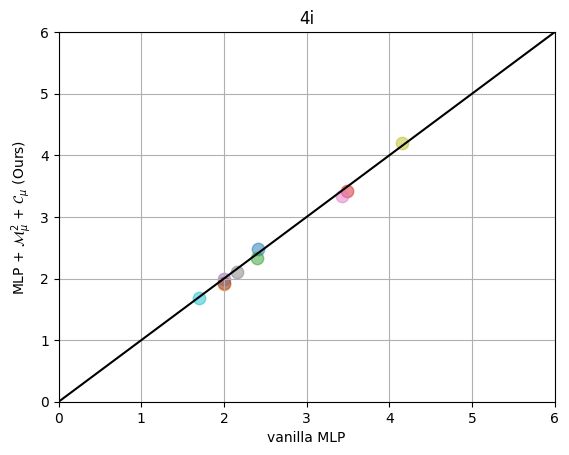

In [19]:
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.grid()
plt.plot([0, 6], [0, 6], c='black')
plt.xlabel('vanilla MLP')
plt.ylabel(r'MLP + $\mathcal{M}_{\mu}^2$ + $\mathcal{C}_{\mu}$ (Ours)')
plt.title('4i')

for mlp_metric, reg_metric in zip(divs['mlp'], divs['reg']):
    plt.scatter([mlp_metric], [reg_metric], s=80, alpha=0.5)